In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [18]:
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt

In [53]:
# Step 1: Download the data
ticker = "BCE.TO"  # S&P/TSX Composite Index
data = yf.download(ticker, start="2010-01-01", end="2024-11-15")
data = data[['Close']]  # Use closing price

# Step 2: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

[*********************100%***********************]  1 of 1 completed


In [54]:
# Define a function to create sequences for LSTM
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [55]:
# Prepare training and test datasets
sequence_length = 60
split_fraction = 0.8  # 80% training, 20% test
train_size = int(len(scaled_data) * split_fraction)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - sequence_length:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape data to (samples, time steps, features) for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [56]:
# Step 3: Build the LSTM model using the Functional API with an Input layer
input_layer = Input(shape=(X_train.shape[1], 1))
x = LSTM(units=50, return_sequences=True)(input_layer)
x = LSTM(units=50, return_sequences=False)(x)
x = Dense(units=25)(x)
output_layer = Dense(units=1)(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')


In [57]:
# Step 4: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0539 - val_loss: 0.0012
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.0236e-04 - val_loss: 0.0011
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.5826e-04 - val_loss: 0.0013
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.8520e-04 - val_loss: 0.0010
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.8054e-04 - val_loss: 9.9645e-04
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.9471e-04 - val_loss: 9.7165e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.5148e-04 - val_loss: 8.8698e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.6589e-04 - val_loss: 8.3175e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.0056e-04 - val_loss: 0.0014
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.0809e-04 - val_loss: 7.3682e-04


In [59]:
# Step 5: Make Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


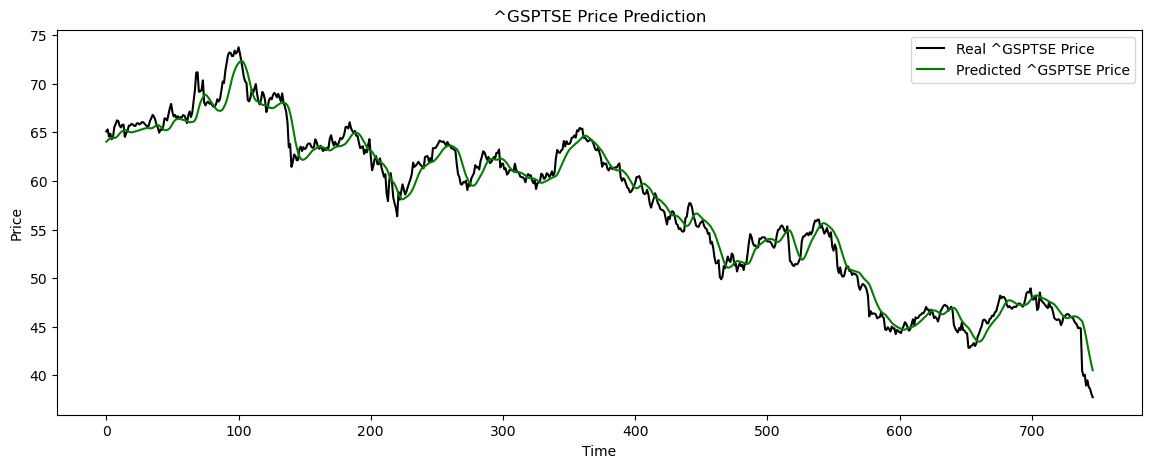

In [60]:
# Plot the results
plt.figure(figsize=(14,5))
plt.plot(real_prices, color='black', label="Real ^GSPTSE Price")
plt.plot(predicted_prices, color='green', label="Predicted ^GSPTSE Price")
plt.title('^GSPTSE Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()